In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.interpolate import interp1d
from math import ceil
import glob
from scipy.integrate import solve_ivp
import seaborn as sns

# Stimulus

In [2]:
def stimulus(fname):
    '''
    Interpolates and creates function for stimulus input from file
    :param fname: stimulus input
    :return: voltage function
    '''
    
    v_m = np.loadtxt(fname)
    v_m = interp1d(v_m[:, 0] * 1000, v_m[:, 1], kind='cubic', fill_value="extrapolate")

    return v_m

In [3]:
fname = './pre_ap_voltage.txt'
v_m = stimulus(fname)
print(v_m)

# Transitions

In [4]:
# transition rate functions
# from Bischofberger and Jonas (2002) and Nadkarni et al (2010/2012)
# All in units of ms
# Temperature adjustment from paper
q10 = 2.0  # rxn rate increase with 10 degC temp change; assumuption of uniform
            # q10 for all reactions here
delta_temp = 10.0  # parameters are given at 24C so raise temp by 10C to 34C
                    # (rat internal temp)
temp_comp = q10 ** (delta_temp / 10.)  # change in rxn rate due to deltaT eqtn


# 1ST TRANSITION
v1 = 49.14  # mV


def alpha_1(t):
    '''
    alpha 1 forward transition rate
    :param t: time
    :return: equation for alpha_1
    '''

    a1o = 4.04  # msec-1

    return temp_comp * a1o * np.exp(v_m(t) / v1)


def beta_1(t):
    '''
    beta 1 backward transition rate
    :param t: time int/double value or array
    :return: equation for beta_1
    '''

    b1o = 2.88  # msec-1

    return temp_comp * b1o * np.exp(-v_m(t) / v1)


# 2ND TRANSITION
v2 = 42.08  # mV


def alpha_2(t):
    '''
    alpha 2 forward transition rate
    :param t: time
    :return: equation for alpha_2
    '''

    a2o = 6.70  # msec-1

    return temp_comp * a2o * np.exp(v_m(t) / v2)


def beta_2(t):
    '''
    beta 2 backward transition rate
    :param t: time
    :return: equation for beta_2
    '''

    b2o = 6.30  # msec-1

    return temp_comp * b2o * np.exp(-v_m(t) / v2)


# 3RD TRANSITION
v3 = 55.31  # mV


def alpha_3(t):
    '''
    alpha 3 forward transition rate
    :param t: time
    :return: equation for alpha_3
    '''

    a3o = 4.39  # msec-1

    return temp_comp * a3o * np.exp(v_m(t) / v3)


def beta_3(t):
    '''
    beta 3 backward transition rate
    :param t: time
    :return: equation for beta_3
    '''

    b3o = 8.16  # msec-1

    return temp_comp * b3o * np.exp(-v_m(t) / v3)

# 4TH TRANSITION
v4 = 26.55  # mV


def alpha_4(t):
    '''
    alpha 4 forward transition rate
    :param t: time
    :return: equation for alpha_4
    '''

    a4o = 17.33  # msec-1

    return temp_comp * a4o * np.exp(v_m(t) / v4)


def beta_4(t):
    '''
    beta 4 backward transition rate
    :param t: time
    :return: equation for beta_4
    '''

    b4o = 1.84  # msec-1

    return b4o * np.exp(-v_m(t) / v4)

# CALCIUM INFLUX
# Current influx rate constant (k_ca)
# 1/ms


def k_ca(t):
    f_ca = 511080.18/1802251    # correction factor for only calcium in current
    g_hva = f_ca * 1.55 * 2.4e-12  # conductance (3.72 pS; adjusted for temperature)
    c = 80.36   # mV
    d = 0.3933  # parameter determining current rectification and reversal potential
    e_c = 1.6e-19  # Coulombic charge of one electron (e = F/NA)
    Z_ca = 2  # Charge of calcium ion

    return g_hva * v_m(t) * (d - np.exp(-v_m(t) / c)) / ((1000 ** 2) * Z_ca * e_c * (1 - np.exp(v_m(t) / c)))


# ODE Solver

In [5]:
##########################
####### ODE SOLVER #######
##########################
def vdcc_odes(t, state):
    '''
    ODEs to describe vdcc states according to Markov diagram
    :param t: time
    :param state: states of vdcc
    :return: odes describing each state
    '''

    c0, c1, c2, c3, o, ca = state

    eqtns = []
    eqtns.append(beta_1(t) * c1 - alpha_1(t) * c0)
    eqtns.append(alpha_1(t) * c0 + beta_2(t) * c2 - (beta_1(t) + alpha_2(t)) * c1)
    eqtns.append(alpha_2(t) * c1 + beta_3(t) * c3 - (beta_2(t) + alpha_3(t)) * c2)
    eqtns.append(alpha_3(t) * c2 + beta_4(t) * o - (beta_3(t) + alpha_4(t)) * c3)
    eqtns.append(alpha_4(t) * c3 - beta_4(t) * o)
    eqtns.append(k_ca(t) * o)

    return eqtns


In [6]:
dt = 1e-3
t_start = 0
t_stop = 10
trange = np.arange(t_start, t_stop+dt, dt)
ode_results = solve_ivp(vdcc_odes, [t_start, t_stop+dt], [1, 0, 0, 0, 0, 0],
                        t_eval=trange)

# Euler ODE

In [7]:
##########################
### EULER INTEGRATION ####
##########################

# MAKE THIS BETTER!!!
def euler(y0, t_start, t_stop, dt):
    trange = np.arange(t_start, t_stop + dt, dt)
    
    # Initialize states
    vdcc_c0, vdcc_c1, vdcc_c2, vdcc_c3, vdcc_o, ca = [np.zeros(len(trange)) for _ in range(len(y0))]
    
    # Initial conditions
    vdcc_c0[0] = y0[0]
    vdcc_c1[0] = y0[1]
    vdcc_c2[0] = y0[2]
    vdcc_c3[0] = y0[3]
    vdcc_o[0] = y0[4] 
    ca[0] = y0[5]
    
    # Step forward in time
    for n in range(len(trange) - 1):
        #print(n)
        vdcc_c0[n+1] = vdcc_c0[n] + (beta_1(trange[n]) * vdcc_c1[n] - alpha_1(trange[n]) * vdcc_c0[n])*dt
        vdcc_c1[n+1] = vdcc_c1[n] + (alpha_1(trange[n]) * vdcc_c0[n] + beta_2(trange[n]) * vdcc_c2[n] - (beta_1(trange[n]) + alpha_2(trange[n])) * vdcc_c1[n])*dt
        vdcc_c2[n+1] = vdcc_c2[n] + (alpha_2(trange[n]) * vdcc_c1[n] + beta_3(trange[n]) * vdcc_c3[n] - (beta_2(trange[n]) + alpha_3(trange[n])) * vdcc_c2[n])*dt
        vdcc_c3[n+1] = vdcc_c3[n] + (alpha_3(trange[n]) * vdcc_c2[n] + beta_4(trange[n]) * vdcc_o[n] - (beta_3(trange[n]) + alpha_4(trange[n])) * vdcc_c3[n])*dt
        vdcc_o[n+1] = vdcc_o[n] + (alpha_4(trange[n]) * vdcc_c3[n] - beta_4(trange[n]) * vdcc_o[n])*dt
        ca[n+1] = ca[n] + (k_ca(trange[n]) * vdcc_o[n])*dt
        
    return vdcc_c0, vdcc_c1, vdcc_c2, vdcc_c3, vdcc_o, ca
    
 


In [8]:
# Initial conditions
y0 = [1, 0, 0, 0, 0, 0]

# Time
dt = 1e-3
t_start = 0
t_stop = 10


#vdcc_c0, vdcc_c1, vdcc_c2, vdcc_c3, vdcc_o, ca = euler(y0, t_start, t_stop, dt)

In [9]:
#%timeit -n 1 -r 10 euler(y0, t_start, t_stop, dt)

In [10]:
#%timeit -n 1 -r 10 solve_ivp(vdcc_odes,[t_start, t_stop+dt], [1, 0, 0, 0, 0, 0], t_eval=trange)
#%timeit -n 1 -r 10 markov_vdcc_n(65, trange, dt)

# Markov

In [11]:
##########################
###### MARKOV DATA #######
##########################
def markov_sim(fname):
    N_CHANS=65
    sep_results_df = (pd.read_csv(file) for file in sorted(glob.glob(fname)))
    markov_results = pd.concat(sep_results_df)
    
    # Normalize
    for col_name in markov_results.columns[2:8]:
        markov_results['{}_norm'.format(col_name)] = markov_results[col_name]/N_CHANS
    
    
    # Average across trials
    avg_markov_results = markov_results.groupby('timepoints').mean()
    del avg_markov_results['trial']
    
    markov_results.head()
    
    return markov_results, avg_markov_results

In [12]:
fname = "markov_1000_runs*.csv"
markov_results, avg_markov_results = markov_sim(fname)

# MCell

In [13]:
##########################
####### MCELL DATA #######
##########################
def mcell_sim(fname):
    SEEDS = 50
    DATA_DIM = 2
    T_START = 0
    ITERATIONS = 10000
    T_STEP = 1e-6
    T_STOP = ITERATIONS * T_STEP
    T_RANGE = np.arange(T_START, T_STOP + T_STEP / 2, T_STEP)
    
    # Molecule data file names (ie ca.World.dat)
    mol_files = []
    mol_names = []
    files = sorted(glob.glob(os.path.join(MCELL_DIR,"seed_00001/vdcc_pre_*.World.dat")))
    files[4], files[5] = files[5], files[4]
        
    for file_path in files:
        mol_file = file_path.split('/')[-1]
        mol_files.append(mol_file)
        mol_names.append(mol_file.split('.')[0])
        
    # Initialize data arrays
    # Data is list of np arrays n_mol in length
    mcell_data = []
    for i in range(len(mol_files)):
        mcell_data.append(np.empty([len(T_RANGE), DATA_DIM, SEEDS]))
        # time x features (2 time, val) x seeds
    
    # Add data to all arrays
    for seed in range(SEEDS):
        for i in range(len(mol_files)):
            fname = os.path.join(MCELL_DIR, "seed_{:05d}".format(seed + 1), mol_files[i])
            mcell_data[i][:, :, seed] = pd.read_csv(fname, delim_whitespace=True, header=None)
    
            
    mcell_results = np.copy(mcell_data)
    N_CHANS=65
    for i in range(len(mcell_results)):
        #if i != 5:
        mcell_results[i][:, 1, :] = mcell_results[i][:, 1, :] / N_CHANS
        
    return mcell_results

In [14]:
MCELL_DIR = "/Users/margotwagner/projects/mcell/simple_geom/model_1/" \
            "model_1_vdcceqtns_tchange_nodendrite_files/mcell/output_data/" \
            "react_data/"

mcell_results = mcell_sim(MCELL_DIR)

# Plotting

In [23]:
def all_vdcc_plot(odesolve=False, euler=False, mcell=False, markov=False, incl_std=False):
    
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(3, 2, figsize = (20,20))
    N_CHANS = 65
    
    names = markov_results.columns[9:].values
    
    t_offset = 1.5
    lwidth = 3
    
    ##########
    # MARKOV #
    ##########
    if markov == True:
        if incl_std == False:
            for a, n in zip(ax.flatten(), names):
                sns.lineplot(x=avg_markov_results.index, y=n, data=avg_markov_results, linewidth=lwidth, ax=a)
        else:
            for a, n in zip(ax.flatten(), names):
                sns.lineplot(markov_results["timepoints"], y=n, data=markov_results, 
                             ci="sd", linewidth=lwidth, ax=a, label="Markov")

    for a, i in zip(ax.flatten(), range(ode_results.y.shape[0])):
        #########
        # MCELL #
        #########
        if mcell == True:
            
            mcell_color = 'C3'
            mcell_mean = np.mean(mcell_results[i], axis=2)
            mcell_std = np.std(mcell_results[i], axis=2)
            
            # Plot mean
            a.plot(mcell_mean[:,0]*1000, mcell_mean[:,1], color=mcell_color, linewidth=lwidth, label='MCell')
 
            # Cloud plot for std dev
            if incl_std == True:
                a.fill_between(mcell_mean[:,0]*1000, np.add(mcell_mean[:,1], mcell_std[:,1]), 
                               np.subtract(mcell_mean[:,1], mcell_std[:,1]),alpha=0.3, color=mcell_color)    
                
         
    for a, i in zip(ax.flatten(), range(ode_results.y.shape[0])):
        ##############
        # ODE SOLVER #
        ##############
        if odesolve == True:
            if i != 5: # Ca variance is negative?
                ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])  
                ode_sd = np.sqrt(np.multiply(ode_results.y[i,:], (1 - ode_results.y[i,:]))/N_CHANS)
                
                # Cloud plot for sd
                if incl_std == True:
                    a.fill_between(ode_results.t, np.add(ode_results.y[i,:], ode_sd), 
                                   np.subtract(ode_results.y[i,:], ode_sd),alpha=0.5, color='lightgrey')
                
            a.plot(ode_results.t,ode_results.y[i], color='black', linewidth=lwidth, label="ODE") 
             
        
    # EULER
    #if euler == True:
    #    ax[0,0].plot(trange, vdcc_c0, color='g')
    #    ax[0,1].plot(trange, vdcc_c1, color='g')
    #    ax[1,0].plot(trange, vdcc_c2, color='g')
    #    ax[1,1].plot(trange, vdcc_c3, color='g')
    #    ax[2,0].plot(trange, vdcc_o, color='g')
    #    ax[2,1].plot(trange, ca, color='g')
    #    
    
    
    #####################
    # PLOTTING SETTINGS #
    #####################
    states = ['C0', 'C1', 'C2', 'C3', 'O', '']
    for a, i in zip(ax.flatten(), range(len(states))):
        a.set_xlim(0, 5)
        a.tick_params(labelsize=20)
        a.set_xlabel('time (ms)', fontsize=26)
        a.legend(prop={"size":20})
        a.set_ylabel('fraction of VDCCs ({})'.format(states[i]), fontsize=26)
        
    ax[2,1].set_ylabel('calcium influx per open vdcc'.format(states[i]), fontsize=26)
    
    plt.tight_layout(pad=1, w_pad=6)
    plt.savefig('/Users/margotwagner/projects/FrontiersPaper/figs/vdcc_all.png')
    plt.show()

#all_vdcc_plot(odesolve=True, euler=False, mcell=True, markov=True, incl_std=True)

In [26]:
def close_up():
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(2, 1, figsize = (12,20), dpi=200)
    N_CHANS = 65
    
    names = markov_results.columns[13:].values

    for a, i in zip(ax.flatten(), range(4,6)):
        #########
        # MCELL #
        #########
            
        mcell_color = 'C3'
        mcell_mean = np.mean(mcell_results[i], axis=2)
        mcell_std = np.std(mcell_results[i], axis=2)
        
        # Plot mean
        a.plot(mcell_mean[:,0]*1000, mcell_mean[:,1], color=mcell_color, linewidth=2)
        
        # Cloud plot for std dev
        a.fill_between(mcell_mean[:,0]*1000, np.add(mcell_mean[:,1], mcell_std[:,1]), 
                       np.subtract(mcell_mean[:,1], mcell_std[:,1]),alpha=0.3, color=mcell_color)    
            
            
        ##############
        # ODE SOLVER #
        ##############
        if i != 5: # Ca variance is negative?
            ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])  
            ode_sd = np.sqrt(np.multiply(ode_results.y[i,:], (1 - ode_results.y[i,:]))/N_CHANS)
            
            # Cloud plot for sd
            a.fill_between(ode_results.t, np.add(ode_results.y[i,:], ode_sd), 
                           np.subtract(ode_results.y[i,:], ode_sd),alpha=0.5, color='lightgrey')
            
        a.plot(ode_results.t,ode_results.y[i], color='black', linewidth=2) 
        
    ##########
    # MARKOV #
    ##########
    for a, n in zip(ax.flatten(), names):
        sns.lineplot(x="timepoints", y=n, data=markov_results, ci="sd", linewidth=2, ax=a)
         
    
    for a in ax.flatten():
        a.set_xlim(1, 4.5)
        a.tick_params(labelsize=10)
    plt.show()

# Difference Figure

In [28]:
def vdcc_plot_diff(mcell_plot=False, markov_plot=False):
    '''
    Plot the difference between the ODe and stochastic dynamics curves
    
    '''
    fig, ax = plt.subplots(3, 2, figsize = (20,20))
    N_CHANS = 65
        
    names = markov_results.columns[9:].values 
        
    #########
    # MCELL #
    #########
    if mcell_plot == True:
        for a, i in zip(ax.flatten(), range(ode_results.y.shape[0])):
            # Replace negatives with zero
            ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])
            
            # MCell mean
            mean = np.mean(mcell_results[i], axis=2)
            
            
            # Subtract stochastic from ode
            if i == 5:
                a.plot(ode_results.t, 65*(ode_results.y[i] - mean[:,1]))
            else:
                a.plot(ode_results.t, ode_results.y[i] - mean[:,1])
            
        
    ##########
    # MARKOV #
    ########## 
    if markov_plot == True:
        i = 0
        for a, n in zip(ax.flatten(), names):
            # Replace negatives with zero
            ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])
            
            # Markov
            #sns.lineplot(x=avg_markov_results.index, y=n, data=avg_markov_results, linewidth=1, ax=a, color='r')
            
            # ode
            #a.plot(ode_results.t, ode_results.y[i], color='black')
            
            if n == 'ca_sum_norm':
                a.plot(ode_results.t, 65*(ode_results.y[i] - np.asarray(avg_markov_results[n])))
            else:
                a.plot(ode_results.t, ode_results.y[i] - np.asarray(avg_markov_results[n]))
                   
            i += 1
            
            a.set_title('difference between ode and stochastic simulations, {}'.format(n))
            a.set_xlabel('time')
            a.set_ylabel('difference')
            
    ax[2,1].set_title('difference between ode and stochastic simulations, ca for 65 channels')
            
    plt.show()

In [25]:
#vdcc_plot_diff(mcell_plot=True, markov_plot=True)

In [30]:
def ibm_diff_plot():
    '''
    Plot the difference between the ODe and stochastic dynamics curves
    
    '''
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(2, 1, figsize = (12,20), dpi=200)
    N_CHANS = 65
        
    names = markov_results.columns[13:].values 
        
    #########
    # MCELL #
    #########
    for a, i in zip(ax.flatten(), range(4,6)):
        mcell_color = 'C3'
        
        # Replace negatives with zero
        ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])
        
        # MCell mean
        mean = np.mean(mcell_results[i], axis=2)
        
        
        # Subtract stochastic from ode
        #if i == 5:
        #    a.plot(ode_results.t, 65*(ode_results.y[i] - mean[:,1]))
        #else:
        a.plot(ode_results.t, ode_results.y[i] - mean[:,1], color=mcell_color, linewidth=2)
            
        
    ##########
    # MARKOV #
    ########## 
    i = 4
    for a, n in zip(ax.flatten(), names):
        # Replace negatives with zero
        ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])
        
        # Markov
        #sns.lineplot(x=avg_markov_results.index, y=n, data=avg_markov_results, linewidth=1, ax=a, color='r')
        
        # ode
        #a.plot(ode_results.t, ode_results.y[i], color='black')
        
        if n == 'ca_sum_norm':
            a.plot(ode_results.t, (ode_results.y[i] - np.asarray(avg_markov_results[n])), color='C0', linewidth=2)
        else:
            a.plot(ode_results.t, ode_results.y[i] - np.asarray(avg_markov_results[n]), color='C0', linewidth=2)
               
        i += 1
        
        a.set_title('difference between ode and stochastic simulations, {}'.format(n))
        a.set_xlabel('time')
        a.set_ylabel('difference')
            
    #ax[2,1].set_title('difference between ode and stochastic simulations, ca for 65 channels')
    
    for a in ax.flatten():
        a.set_xlim(1, 4.5)
        #a.tick_params(labelsize=10)
            
    plt.show()

# Paper Figs

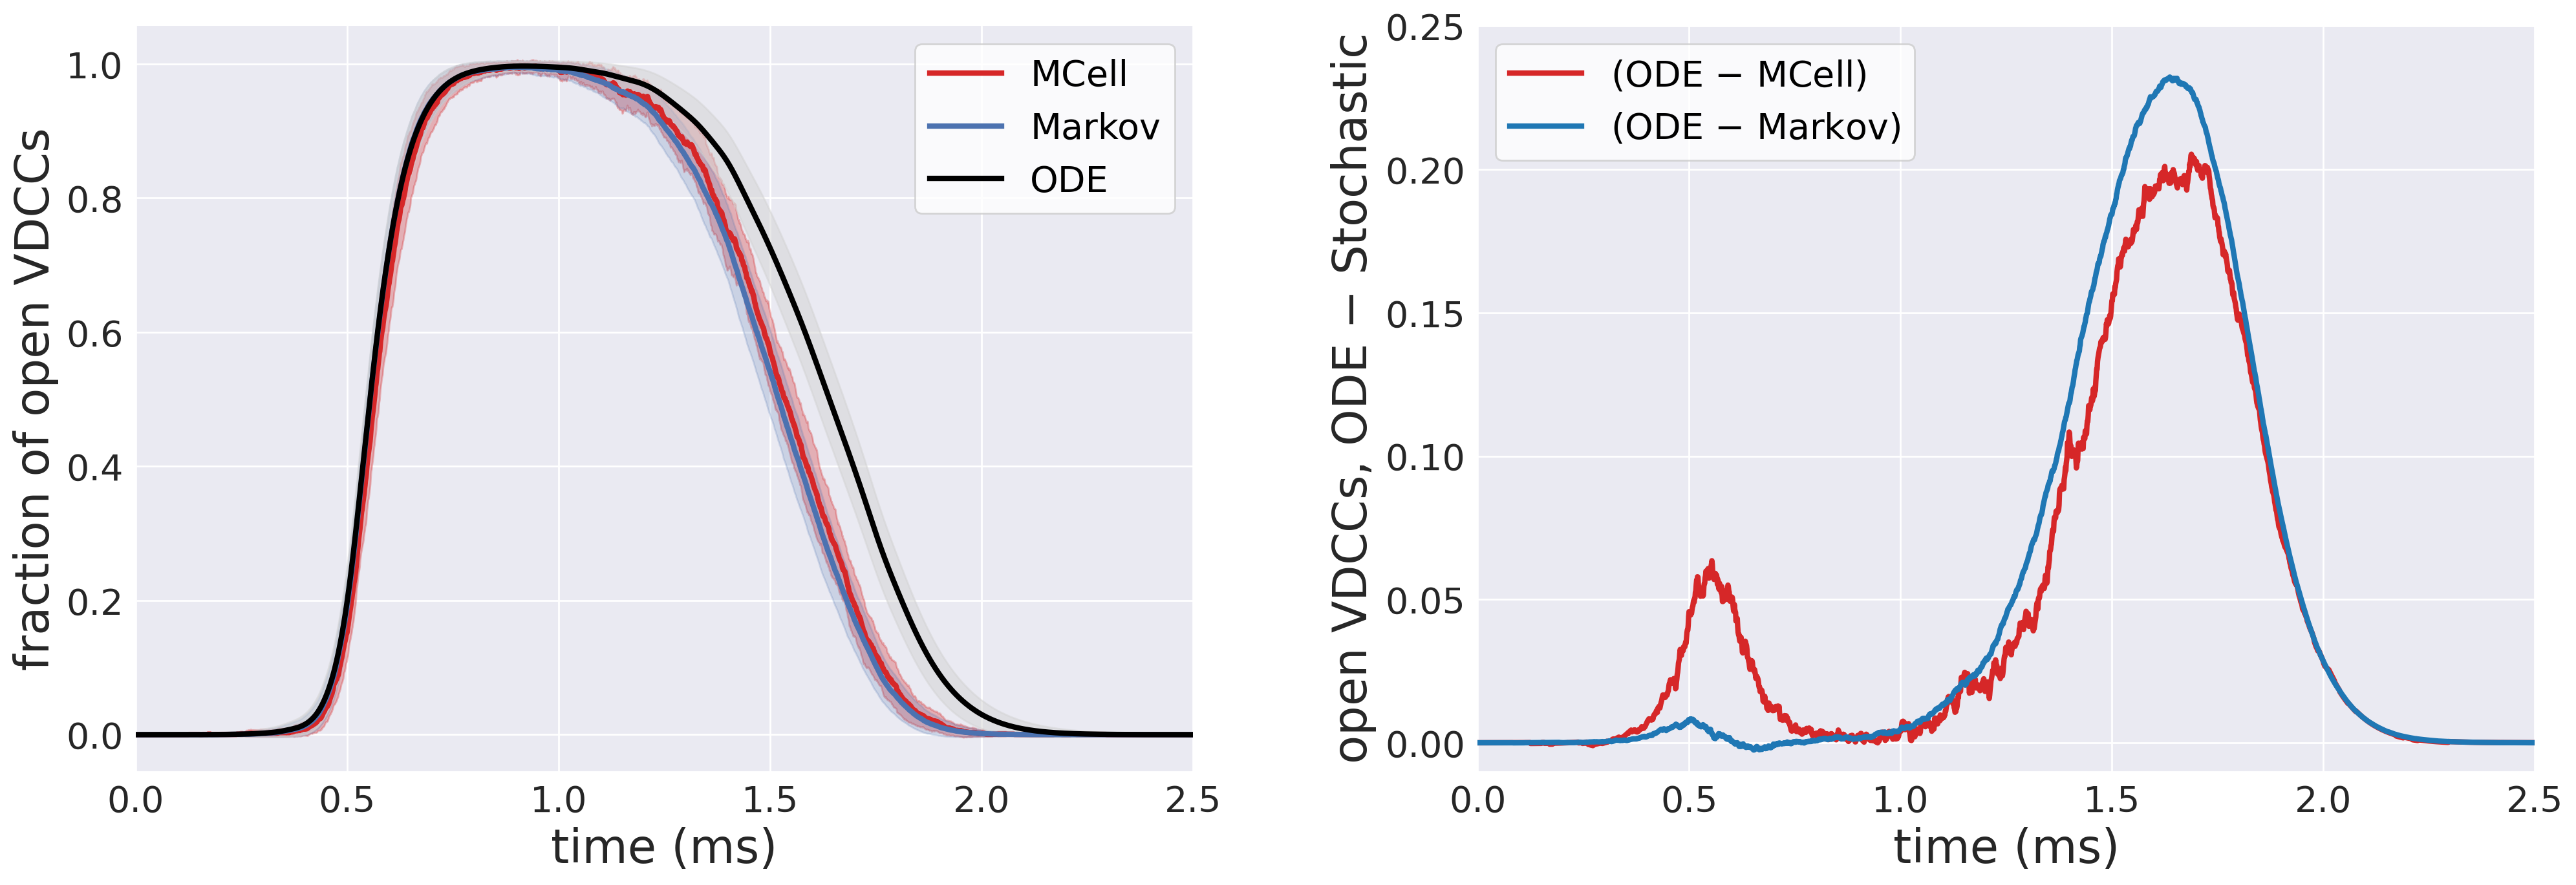

In [15]:
def open_vdccs():
    '''
    Plot open vdcc's across all simulations and difference from ODE
    '''
    t_offset = 1.5
    lwidth = 3
    vdcc_i = 4
    
    
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(1, 2, figsize = (20,7), dpi=200)
    N_CHANS = 65
    
    #name = markov_results.columns[13:14].values
    name = 'vdcc_o_norm'
    
    #########
    # MCELL #
    #########
    # RED
    mcell_color = 'C3'
    mcell_mean = np.mean(mcell_results[vdcc_i], axis=2)
    mcell_std = np.std(mcell_results[vdcc_i], axis=2)
    
    # Plot mean
    ax[0].plot(mcell_mean[:,0]*1000 - t_offset, mcell_mean[:,1], color=mcell_color, linewidth=lwidth, label="MCell")
    
    # Cloud plot for std dev
    ax[0].fill_between(mcell_mean[:,0]*1000 - t_offset, np.add(mcell_mean[:,1], mcell_std[:,1]), 
                   np.subtract(mcell_mean[:,1], mcell_std[:,1]),alpha=0.3, color=mcell_color) 
    
    # Subtract MCell from ODE for plot 2
    ax[1].plot(ode_results.t - t_offset, ode_results.y[vdcc_i] - mcell_mean[:,1], color=mcell_color, 
               linewidth=lwidth, label = '(ODE $-$ MCell)')
    
        
    ###########
    ## MARKOV #
    ###########
    # BLUE
    sns.lineplot(markov_results["timepoints"] - t_offset, y=name, data=markov_results, ci="sd", 
                 linewidth=lwidth, ax=ax[0], label="Markov")
    
    # Subtract Markov from ODE for plot 2
    ax[1].plot(ode_results.t - t_offset, ode_results.y[vdcc_i] - np.asarray(avg_markov_results[name]), 
               color='C0', linewidth=lwidth, label = '(ODE $-$ Markov)')
    
    #########
    #  ODE  #
    #########
    # BLACK
    # replace negative with zero
    ode_results.y[4] = np.where(ode_results.y[vdcc_i]<0, 0, ode_results.y[vdcc_i])  
    ode_sd = np.sqrt(np.multiply(ode_results.y[vdcc_i,:], (1 - ode_results.y[vdcc_i,:]))/N_CHANS)
    
    # Cloud plot for sd
    ax[0].fill_between(ode_results.t - t_offset, np.add(ode_results.y[vdcc_i,:], ode_sd), 
                   np.subtract(ode_results.y[vdcc_i,:], ode_sd),alpha=0.5, color='lightgrey')
    
    ax[0].plot(ode_results.t - t_offset,ode_results.y[vdcc_i], color='black', linewidth=lwidth, label="ODE") 
    
    #####################
    # PLOTTING SETTINGS #
    #####################
    ax[0].set_xlim(0, 2.5)
    #ax[0].set_ylim(0, 1.2)
    ax[0].tick_params(labelsize=20)
    ax[0].set_ylabel('fraction of open VDCCs', fontsize=26)
    ax[0].set_xlabel('time (ms)', fontsize=26)
    ax[0].legend(prop={"size":20})
    
    ax[1].set_ylim(-0.01, 0.25)
    ax[1].set_xlim(0, 2.5)
    ax[1].tick_params(labelsize=20)
    ax[1].set_ylabel('open VDCCs, ODE $-$ Stochastic', fontsize=26)
    ax[1].set_xlabel('time (ms)', fontsize=26)
    ax[1].legend(prop={"size":20})
    
    plt.tight_layout(pad=1, w_pad=6)
    plt.savefig('/Users/margotwagner/projects/FrontiersPaper/figs/vdcc.png')
    plt.show()
    
open_vdccs()
    

<ipython-input-16-a9a5abd1efe2>:54: RuntimeWarning: invalid value encountered in sqrt
  ode_sd = np.sqrt(np.multiply(ode_results.y[vdcc_i,:], (1 - ode_results.y[vdcc_i,:]))/N_CHANS)


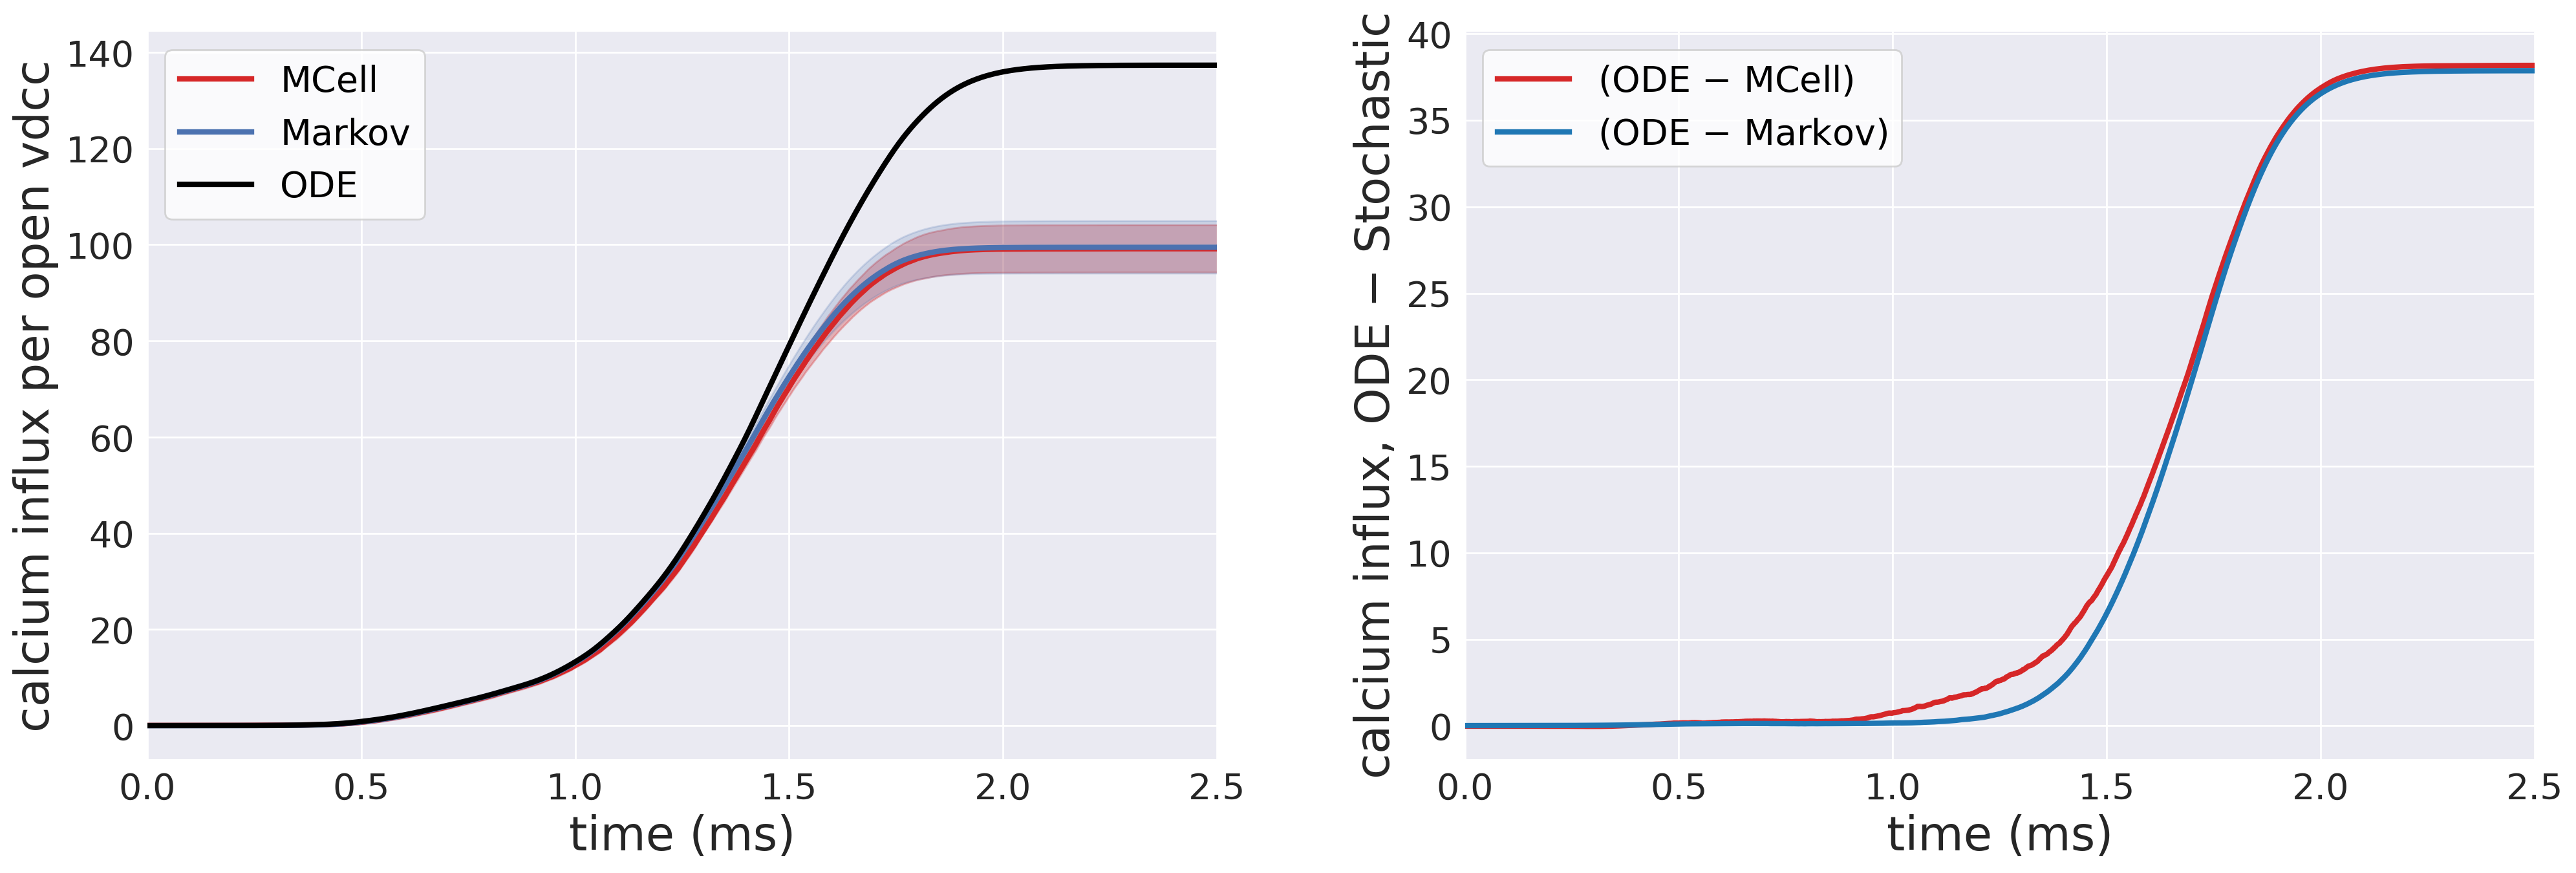

In [16]:
def ca_fig():
    '''
    Plot open vdcc's across all simulations and difference from ODE
    '''
    t_offset = 1.5
    lwidth = 3
    vdcc_i = 5
    
    
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(1, 2, figsize = (20,7), dpi=200)
    N_CHANS = 65
    
    #name = markov_results.columns[13:14].values
    name = 'ca_sum_norm'
    
    #########
    # MCELL #
    #########
    # RED
    mcell_color = 'C3'
    mcell_mean = np.mean(mcell_results[vdcc_i], axis=2)
    mcell_std = np.std(mcell_results[vdcc_i], axis=2)
    
    # Plot mean
    ax[0].plot(mcell_mean[:,0]*1000 - t_offset, mcell_mean[:,1], color=mcell_color, linewidth=lwidth, label="MCell")
    
    # Cloud plot for std dev
    ax[0].fill_between(mcell_mean[:,0]*1000 - t_offset, np.add(mcell_mean[:,1], mcell_std[:,1]), 
                   np.subtract(mcell_mean[:,1], mcell_std[:,1]),alpha=0.3, color=mcell_color) 
    
    # Subtract MCell from ODE for plot 2
    ax[1].plot(ode_results.t - t_offset, ode_results.y[vdcc_i] - mcell_mean[:,1], color=mcell_color, 
               linewidth=lwidth, label = '(ODE $-$ MCell)')
    
        
    ###########
    ## MARKOV #
    ###########
    # BLUE
    sns.lineplot(markov_results["timepoints"] - t_offset, y=name, data=markov_results, ci="sd", 
                 linewidth=lwidth, ax=ax[0], label="Markov")
    
    # Subtract Markov from ODE for plot 2
    ax[1].plot(ode_results.t - t_offset, ode_results.y[vdcc_i] - np.asarray(avg_markov_results[name]), 
               color='C0', linewidth=lwidth, label = '(ODE $-$ Markov)')
    
    #########
    #  ODE  #
    #########
    # BLACK
    # replace negative with zero
    ode_results.y[4] = np.where(ode_results.y[vdcc_i]<0, 0, ode_results.y[vdcc_i])  
    ode_sd = np.sqrt(np.multiply(ode_results.y[vdcc_i,:], (1 - ode_results.y[vdcc_i,:]))/N_CHANS)
    
    # Cloud plot for sd
    ax[0].fill_between(ode_results.t - t_offset, np.add(ode_results.y[vdcc_i,:], ode_sd), 
                   np.subtract(ode_results.y[vdcc_i,:], ode_sd),alpha=0.5, color='lightgrey')
    
    ax[0].plot(ode_results.t - t_offset,ode_results.y[vdcc_i], color='black', linewidth=lwidth, label="ODE") 
    
    #####################
    # PLOTTING SETTINGS #
    #####################
    ax[0].set_xlim(0, 2.5)
    #ax[0].set_ylim(0, 1.2)
    ax[0].tick_params(labelsize=20)
    ax[0].set_ylabel('calcium influx per open vdcc', fontsize=26)
    ax[0].set_xlabel('time (ms)', fontsize=26)
    ax[0].legend(prop={"size":20})
    
    #ax[1].set_ylim(-0.01, 0.25)
    ax[1].set_xlim(0, 2.5)
    ax[1].tick_params(labelsize=20)
    ax[1].set_ylabel('calcium influx, ODE $-$ Stochastic', fontsize=26)
    ax[1].set_xlabel('time (ms)', fontsize=26)
    ax[1].legend(prop={"size":20})
    
    plt.tight_layout(pad=1, w_pad=6)
    plt.savefig('/Users/margotwagner/projects/FrontiersPaper/figs/vdcc_ca.png')
    plt.show()
    
ca_fig()

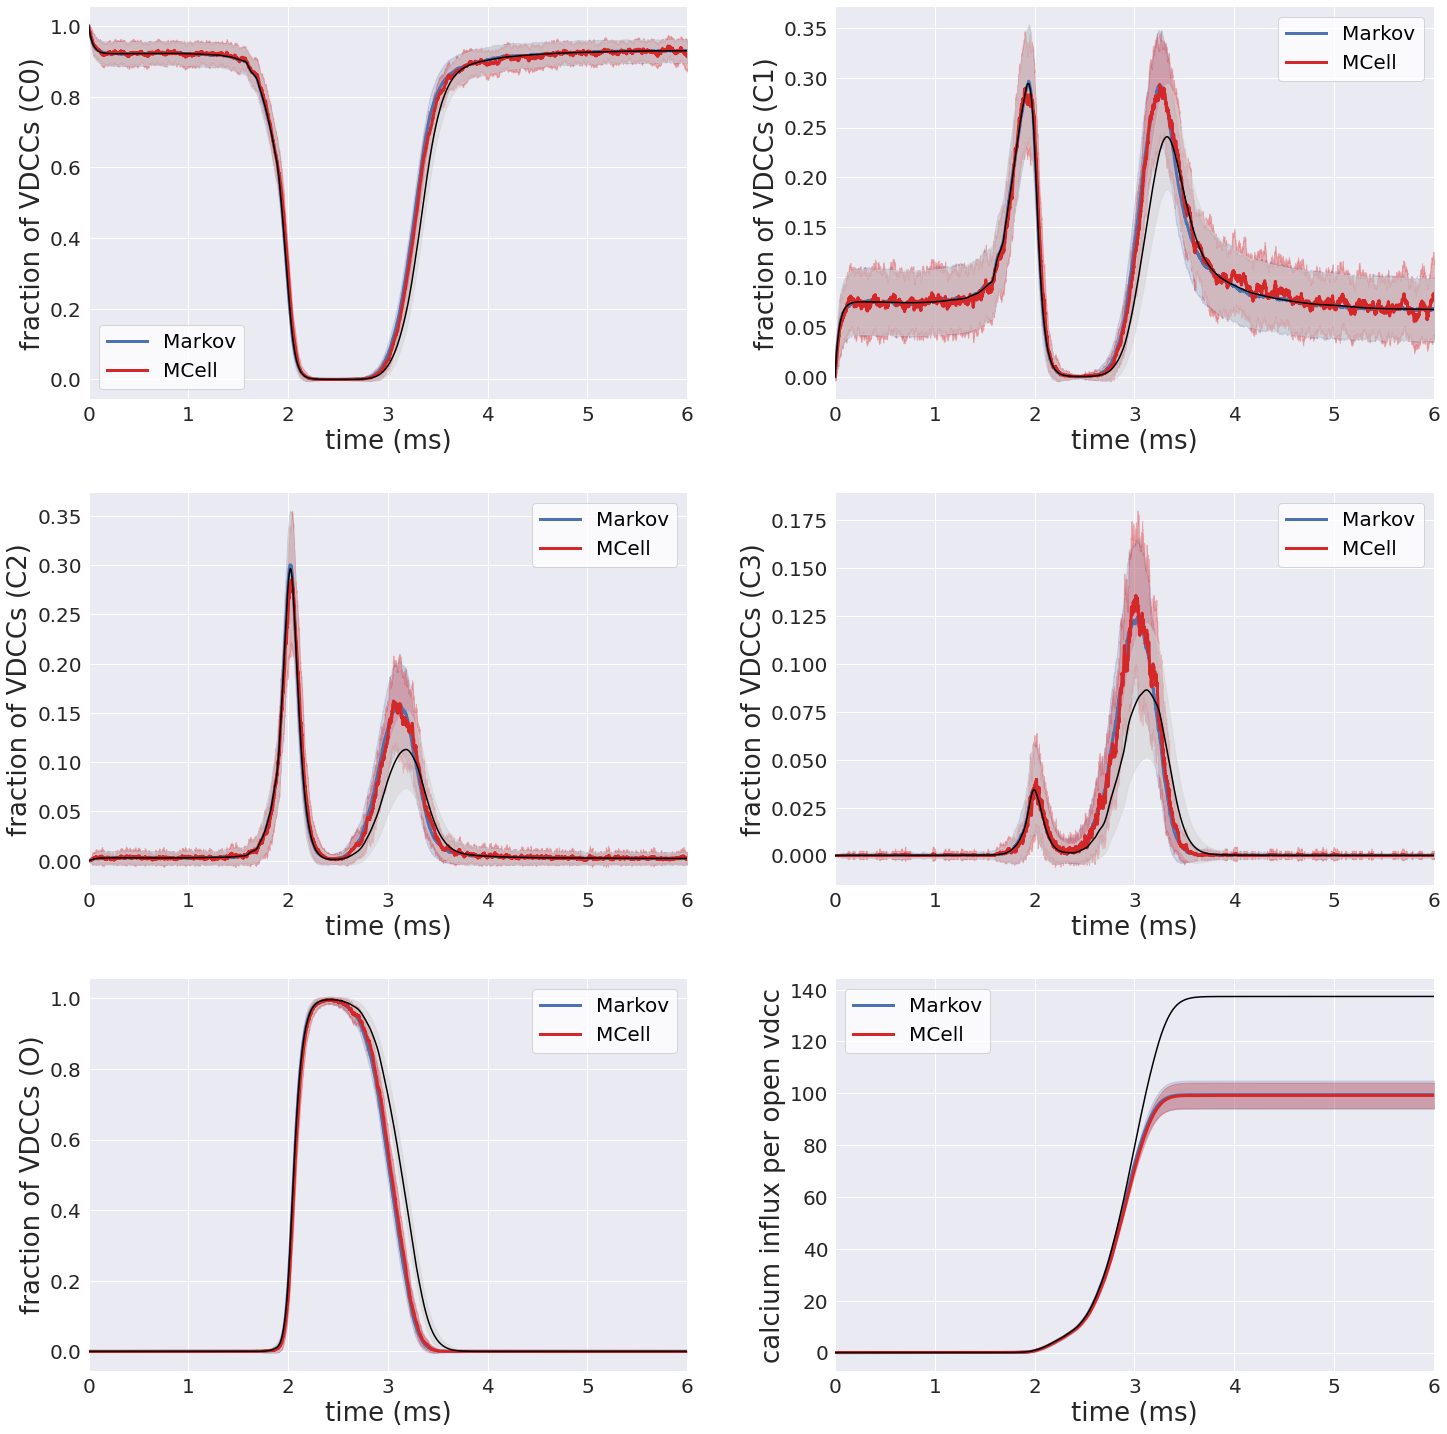

In [15]:
def all_vdcc_plot(odesolve=False, euler=False, mcell=False, markov=False, incl_std=False):
    
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(3, 2, figsize = (20,20))
    N_CHANS = 65
    
    names = markov_results.columns[9:].values
    
    t_offset = 1.5
    lwidth = 3
    
    ##########
    # MARKOV #
    ##########
    if markov == True:
        if incl_std == False:
            for a, n in zip(ax.flatten(), names):
                sns.lineplot(x=avg_markov_results.index, y=n, data=avg_markov_results, linewidth=lwidth, ax=a)
        else:
            for a, n in zip(ax.flatten(), names):
                sns.lineplot(markov_results["timepoints"], y=n, data=markov_results, 
                             ci="sd", linewidth=lwidth, ax=a, label="Markov")

    for a, i in zip(ax.flatten(), range(ode_results.y.shape[0])):
        #########
        # MCELL #
        #########
        if mcell == True:
            
            mcell_color = 'C3'
            mcell_mean = np.mean(mcell_results[i], axis=2)
            mcell_std = np.std(mcell_results[i], axis=2)
            
            # Plot mean
            a.plot(mcell_mean[:,0]*1000, mcell_mean[:,1], color=mcell_color, linewidth=lwidth, label='MCell')
 
            # Cloud plot for std dev
            if incl_std == True:
                a.fill_between(mcell_mean[:,0]*1000, np.add(mcell_mean[:,1], mcell_std[:,1]), 
                               np.subtract(mcell_mean[:,1], mcell_std[:,1]),alpha=0.3, color=mcell_color) 
                
        if odesolve == True:
            if i != 5: # Ca variance is negative?
                ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])  
                ode_sd = np.sqrt(np.multiply(ode_results.y[i,:], (1 - ode_results.y[i,:]))/N_CHANS)
                
                # Cloud plot for sd
                if incl_std == True:
                    a.fill_between(ode_results.t, np.add(ode_results.y[i,:], ode_sd), 
                                   np.subtract(ode_results.y[i,:], ode_sd),alpha=0.5, color='lightgrey')
                
            a.plot(ode_results.t,ode_results.y[i], color='black') 
                
         
    #for a, i in zip(ax.flatten(), range(ode_results.y.shape[0])):
    #    ##############
    #    # ODE SOLVER #
    #    ##############
    #    if odesolve == True:
    #        if i != 5: # Ca variance is negative?
    #            ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])  
    #            ode_sd = np.sqrt(np.multiply(ode_results.y[i,:], (1 - ode_results.y[i,:]))/N_CHANS)
    #            
    #            # Cloud plot for sd
    #            if incl_std == True:
    #                a.fill_between(ode_results.t, np.add(ode_results.y[i,:], ode_sd), 
    #                               np.subtract(ode_results.y[i,:], ode_sd),alpha=0.5, color='lightgrey')
    #            
    #        a.plot(ode_results.t,ode_results.y[i], color='black', linewidth=lwidth, label="ODE") 
    #         
        
    # EULER
    #if euler == True:
    #    ax[0,0].plot(trange, vdcc_c0, color='g')
    #    ax[0,1].plot(trange, vdcc_c1, color='g')
    #    ax[1,0].plot(trange, vdcc_c2, color='g')
    #    ax[1,1].plot(trange, vdcc_c3, color='g')
    #    ax[2,0].plot(trange, vdcc_o, color='g')
    #    ax[2,1].plot(trange, ca, color='g')
    #    
    
    
    #####################
    # PLOTTING SETTINGS #
    #####################
    states = ['C0', 'C1', 'C2', 'C3', 'O', '']
    for a, i in zip(ax.flatten(), range(len(states))):
        a.set_xlim(0, 6)
        a.tick_params(labelsize=20)
        a.set_xlabel('time (ms)', fontsize=26)
        a.legend(prop={"size":20})
        a.set_ylabel('fraction of VDCCs ({})'.format(states[i]), fontsize=26)
        
    ax[2,1].set_ylabel('calcium influx per open vdcc'.format(states[i]), fontsize=26)
    
    plt.tight_layout(pad=1, w_pad=6)
    plt.savefig('/Users/margotwagner/projects/FrontiersPaper/figs/vdcc_all.png')
    plt.show()

all_vdcc_plot(odesolve=True, euler=False, mcell=True, markov=True, incl_std=True)

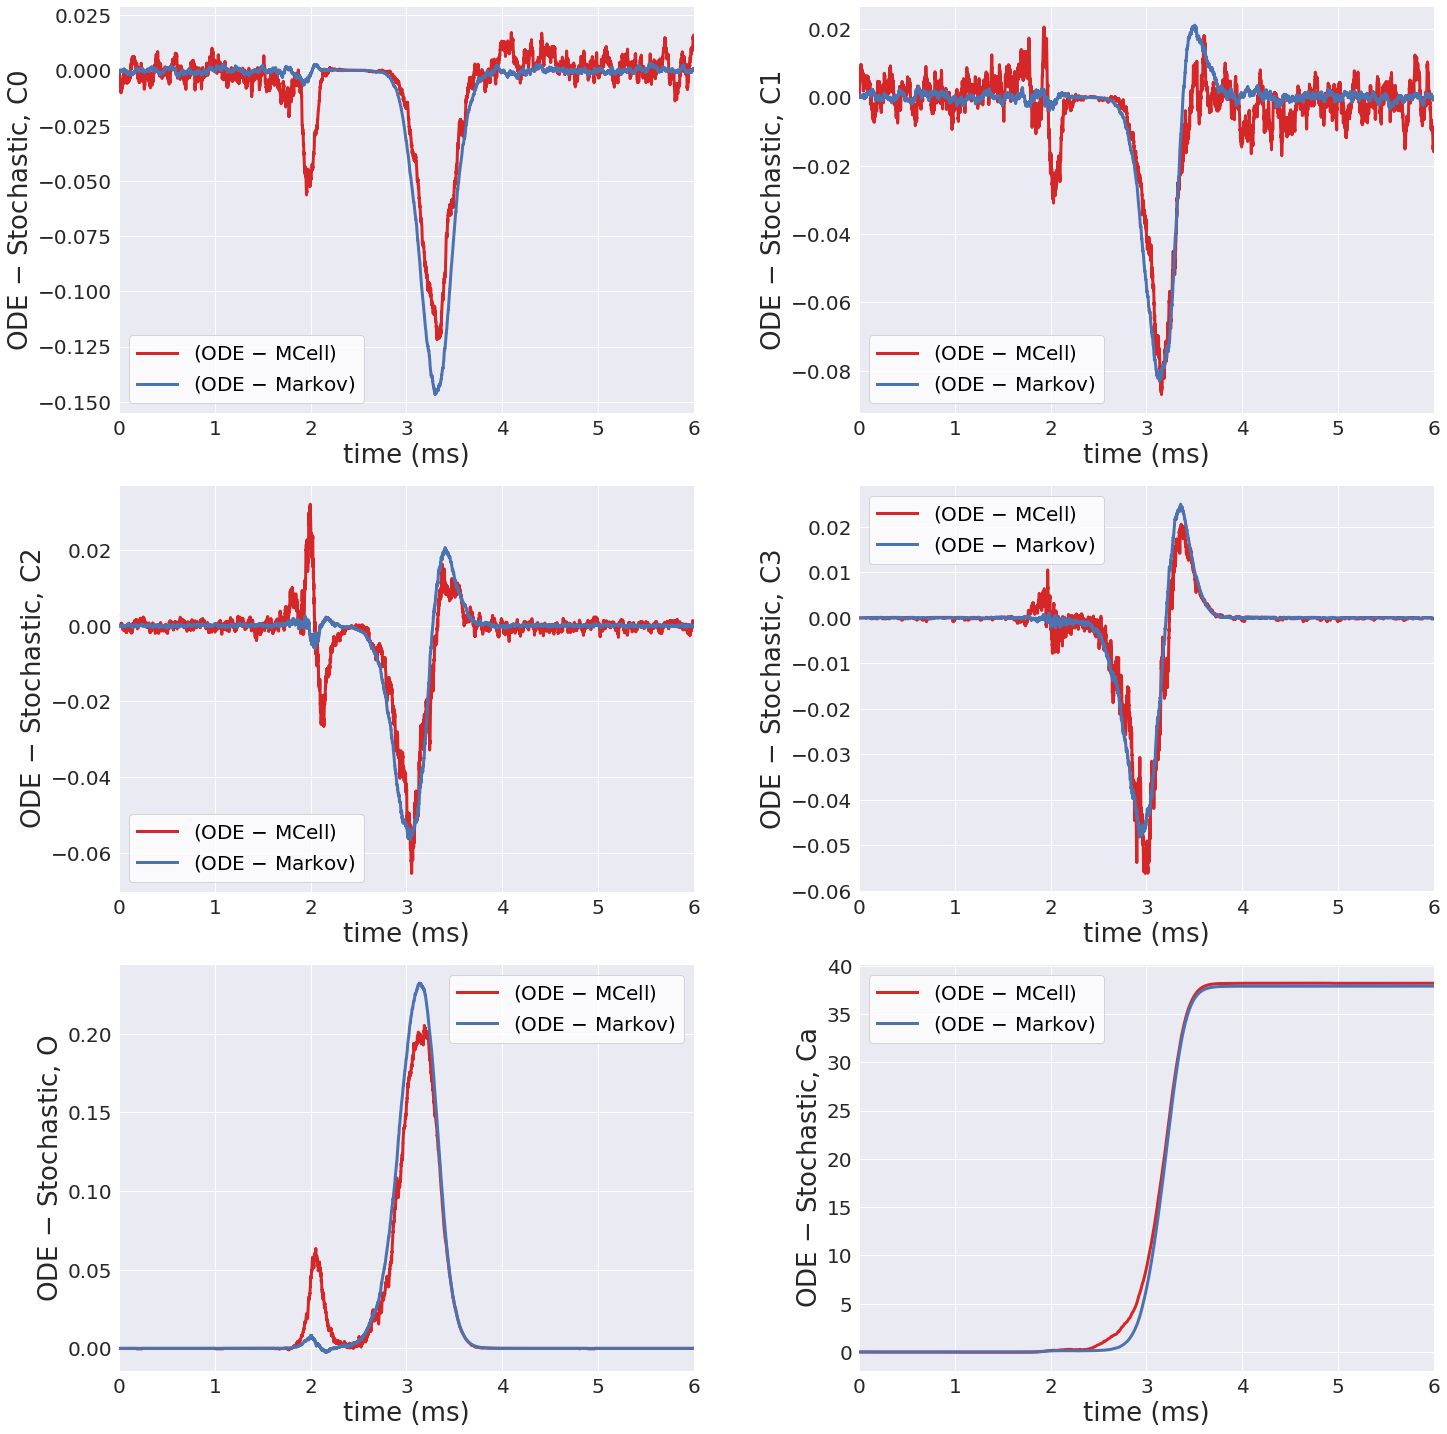

In [16]:
def vdcc_plot_diff(mcell_plot=False, markov_plot=False):
    '''
    Plot the difference between the ODe and stochastic dynamics curves
    
    '''
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(3, 2, figsize = (20,20))
    N_CHANS = 65
        
    names = markov_results.columns[9:].values 
    
    lwidth = 3
        
    #########
    # MCELL #
    #########
    if mcell_plot == True:
        for a, i in zip(ax.flatten(), range(ode_results.y.shape[0])):
            mcell_color = 'C3'
            
            # Replace negatives with zero
            ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])
            
            # MCell mean
            mean = np.mean(mcell_results[i], axis=2)
            
            
            # Subtract stochastic from ode
            a.plot(ode_results.t, ode_results.y[i] - mean[:,1], color=mcell_color, 
                   linewidth=lwidth, label='(ODE $-$ MCell)')
            
        
    ##########
    # MARKOV #
    ########## 
    if markov_plot == True:
        i = 0
        states = ['C0', 'C1', 'C2', 'C3', 'O', 'Ca']
        for a, n in zip(ax.flatten(), names):
            # Replace negatives with zero
            ode_results.y[i] = np.where(ode_results.y[i]<0, 0, ode_results.y[i])
            
            # Markov
            #sns.lineplot(x=avg_markov_results.index, y=n, data=avg_markov_results, linewidth=1, ax=a, color='r')
            
            # ode
            #a.plot(ode_results.t, ode_results.y[i], color='black')
            
            a.plot(ode_results.t, ode_results.y[i] - np.asarray(avg_markov_results[n]), 
                   linewidth=lwidth, label = '(ODE $-$ Markov)')
                   
            a.tick_params(labelsize=20)
            a.set_xlabel('time (ms)', fontsize=26)
            a.set_ylabel('ODE $-$ Stochastic, {}'.format(states[i]), fontsize=26)
            a.legend(prop={"size":20})
            a.set_xlim(0, 6)
            
            i += 1
            
    plt.tight_layout(pad=1, w_pad=6)
    plt.savefig('/Users/margotwagner/projects/FrontiersPaper/figs/vdcc_diff_all.png')
    plt.show()
    
vdcc_plot_diff(mcell_plot=True, markov_plot=True)

# Distributions

In [116]:
#sns.distplot()
#for a, i in zip(ax.flatten(), range(4,6)):
for i in range(6):
        #########
        # MCELL #
        #########
            
        mcell_color = 'C3'
        mcell_mean = np.mean(mcell_results[i], axis=2)
        mcell_std = np.std(mcell_results[i], axis=2)
        
mcell_mean.shape

(10001, 2)

Markov Open VDCCs (very different from ODE)

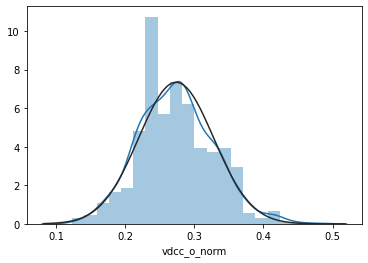

In [41]:
from scipy import stats
#sns.distplot(markov_results.loc[markov_results['timepoints'] == 3.137]['vdcc_o_norm'], fit=stats.norm, bins=30)
sns.distplot(markov_results.loc[markov_results['timepoints'] == 3.137]['vdcc_o_norm'], fit=stats.norm, bins=20)
plt.show()

Markov Open VDCCs (similar to ODE)

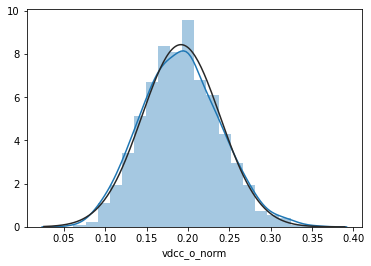

In [42]:
#sns.distplot(markov_results.loc[markov_results['timepoints'] == 2.0]['vdcc_o_norm'], fit=stats.norm, bins=30)
sns.distplot(markov_results.loc[markov_results['timepoints'] == 2.0]['vdcc_o_norm'], fit=stats.norm, bins=20)
plt.show()

MCell Open VDCCs (very different from ODE)

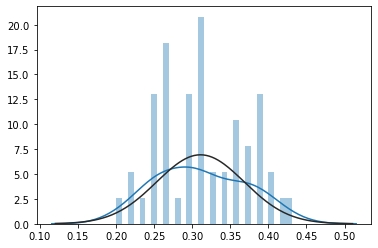

In [43]:
sns.distplot(mcell_results[4, int(3.137/(1e-3)), 1, :], fit=stats.norm, bins=30)
plt.show()

Markov Open VDCCs (similar to ODE)

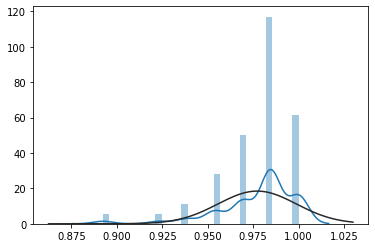

In [48]:
sns.distplot(mcell_results[4, int(2.6/(1e-3)), 1, :], fit=stats.norm, bins=30)
plt.show()

# SDE

In [ ]:
# np.random.normal(mean, std dev, length)
dt = 1e-3
t_start = 0
t_stop = 10
trange = np.arange(t_start, t_stop + dt, dt)

noise = np.random.normal(0, rms_noise, len(t))

plt.plot(trange, noise)

In [121]:
##########################
### SDE EM INTEGRATION ###
##########################
from numpy.random import normal

# Initial conditions
y0 = [1, 0, 0, 0, 0, 0]

# Time
dt = 1e-3
t_start = 0
t_stop = 10
trange = np.arange(t_start, t_stop + dt, dt)


# Initialize states
#sde_results = [np.zeros(len(trange)) for _ in range(len(y0))]
vdcc_c0, vdcc_c1, vdcc_c2, vdcc_c3, vdcc_o, ca = [np.zeros(len(trange)) for _ in range(len(y0))]

# Initial conditions
for i in range(len(sde_results)):
    sde_results[i][0] = y0[i]
print(sde_results)
vdcc_c0[0] = y0[0]
vdcc_c1[0] = y0[1]
vdcc_c2[0] = y0[2]
vdcc_c3[0] = y0[3]
vdcc_o[0] = y0[4] 
ca[0] = y0[5]

# Step forward in time
for n in range(len(trange) - 1):
   # #print(n)
   # vdcc_c0[n+1] = vdcc_c0[n] + (beta_1(trange[n]) * vdcc_c1[n] - alpha_1(trange[n]) * vdcc_c0[n] 
   #                              + normal(vdcc_c0[n], np.sqrt(vdcc_c0[n]*(1 - vdcc_c0[n]))))*dt
   # 
   # vdcc_c1[n+1] = vdcc_c1[n] + (alpha_1(trange[n]) * vdcc_c0[n] + beta_2(trange[n]) * vdcc_c2[n] 
   #                              - (beta_1(trange[n]) + alpha_2(trange[n])) * vdcc_c1[n] 
   #                              + normal(vdcc_c1[n], np.sqrt(vdcc_c1[n]*(1 - vdcc_c1[n]))))*dt
   # 
   # vdcc_c2[n+1] = vdcc_c2[n] + (alpha_2(trange[n]) * vdcc_c1[n] + beta_3(trange[n]) * vdcc_c3[n] 
   #                              - (beta_2(trange[n]) + alpha_3(trange[n])) * vdcc_c2[n] 
   #                              + normal(vdcc_c2[n], np.sqrt(vdcc_c2[n]*(1 - vdcc_c2[n]))))*dt
   # 
   # vdcc_c3[n+1] = vdcc_c3[n] + (alpha_3(trange[n]) * vdcc_c2[n] + beta_4(trange[n]) * vdcc_o[n] 
   #                              - (beta_3(trange[n]) + alpha_4(trange[n])) * vdcc_c3[n] 
   #                              + normal(vdcc_c3[n], np.sqrt(vdcc_c3[n]*(1 - vdcc_c3[n]))))*dt
   # 
   # vdcc_o[n+1] = vdcc_o[n] + (alpha_4(trange[n]) * vdcc_c3[n] - beta_4(trange[n]) * vdcc_o[n] 
   #                            + normal(vdcc_o[n], np.sqrt(vdcc_o[n]*(1 - vdcc_o[n]))))*dt
   # 
   # ca[n+1] = ca[n] + (k_ca(trange[n]) * vdcc_o[n] + normal(ca[n], np.sqrt(ca[n]*(1 - ca[n]))))*dt
    
        #print(n)
    vdcc_c0[n+1] = vdcc_c0[n] + (beta_1(trange[n]) * vdcc_c1[n] - alpha_1(trange[n]) * vdcc_c0[n] 
                                 + normal(0, np.sqrt(vdcc_c0[n]*(1 - vdcc_c0[n]))))*dt
    
    vdcc_c1[n+1] = vdcc_c1[n] + (alpha_1(trange[n]) * vdcc_c0[n] + beta_2(trange[n]) * vdcc_c2[n] 
                                 - (beta_1(trange[n]) + alpha_2(trange[n])) * vdcc_c1[n] 
                                 + normal(0, np.sqrt(vdcc_c1[n]*(1 - vdcc_c1[n]))))*dt
    
    vdcc_c2[n+1] = vdcc_c2[n] + (alpha_2(trange[n]) * vdcc_c1[n] + beta_3(trange[n]) * vdcc_c3[n] 
                                 - (beta_2(trange[n]) + alpha_3(trange[n])) * vdcc_c2[n] 
                                 + normal(0, np.sqrt(vdcc_c2[n]*(1 - vdcc_c2[n]))))*dt
    
    vdcc_c3[n+1] = vdcc_c3[n] + (alpha_3(trange[n]) * vdcc_c2[n] + beta_4(trange[n]) * vdcc_o[n] 
                                 - (beta_3(trange[n]) + alpha_4(trange[n])) * vdcc_c3[n] 
                                 + normal(0, np.sqrt(vdcc_c3[n]*(1 - vdcc_c3[n]))))*dt
    
    vdcc_o[n+1] = vdcc_o[n] + (alpha_4(trange[n]) * vdcc_c3[n] - beta_4(trange[n]) * vdcc_o[n] 
                               + normal(0, np.sqrt(vdcc_o[n]*(1 - vdcc_o[n]))))*dt
    
    ca[n+1] = ca[n] + (k_ca(trange[n]) * vdcc_o[n] + normal(0, np.sqrt(ca[n]*(1 - ca[n]))))*dt
    
sde_results = [vdcc_c0, vdcc_c1, vdcc_c2, vdcc_c3, vdcc_o, ca]

[array([1.        , 0.99905574, 0.99815273, ...,        nan,        nan,
              nan]), array([0.        , 0.00194426, 0.00379865, ...,        nan,        nan,
              nan]), array([0.00000000e+00, 0.00000000e+00, 4.93653211e-06, ...,
                  nan,            nan,            nan]), array([ 0.,  0.,  0., ..., nan, nan, nan]), array([ 0.,  0.,  0., ..., nan, nan, nan]), array([ 0.,  0.,  0., ..., nan, nan, nan])]


<ipython-input-121-ea40051ecb9c>:68: RuntimeWarning: invalid value encountered in sqrt
  + normal(0, np.sqrt(vdcc_c3[n]*(1 - vdcc_c3[n]))))*dt
<ipython-input-121-ea40051ecb9c>:73: RuntimeWarning: invalid value encountered in sqrt
  ca[n+1] = ca[n] + (k_ca(trange[n]) * vdcc_o[n] + normal(0, np.sqrt(ca[n]*(1 - ca[n]))))*dt


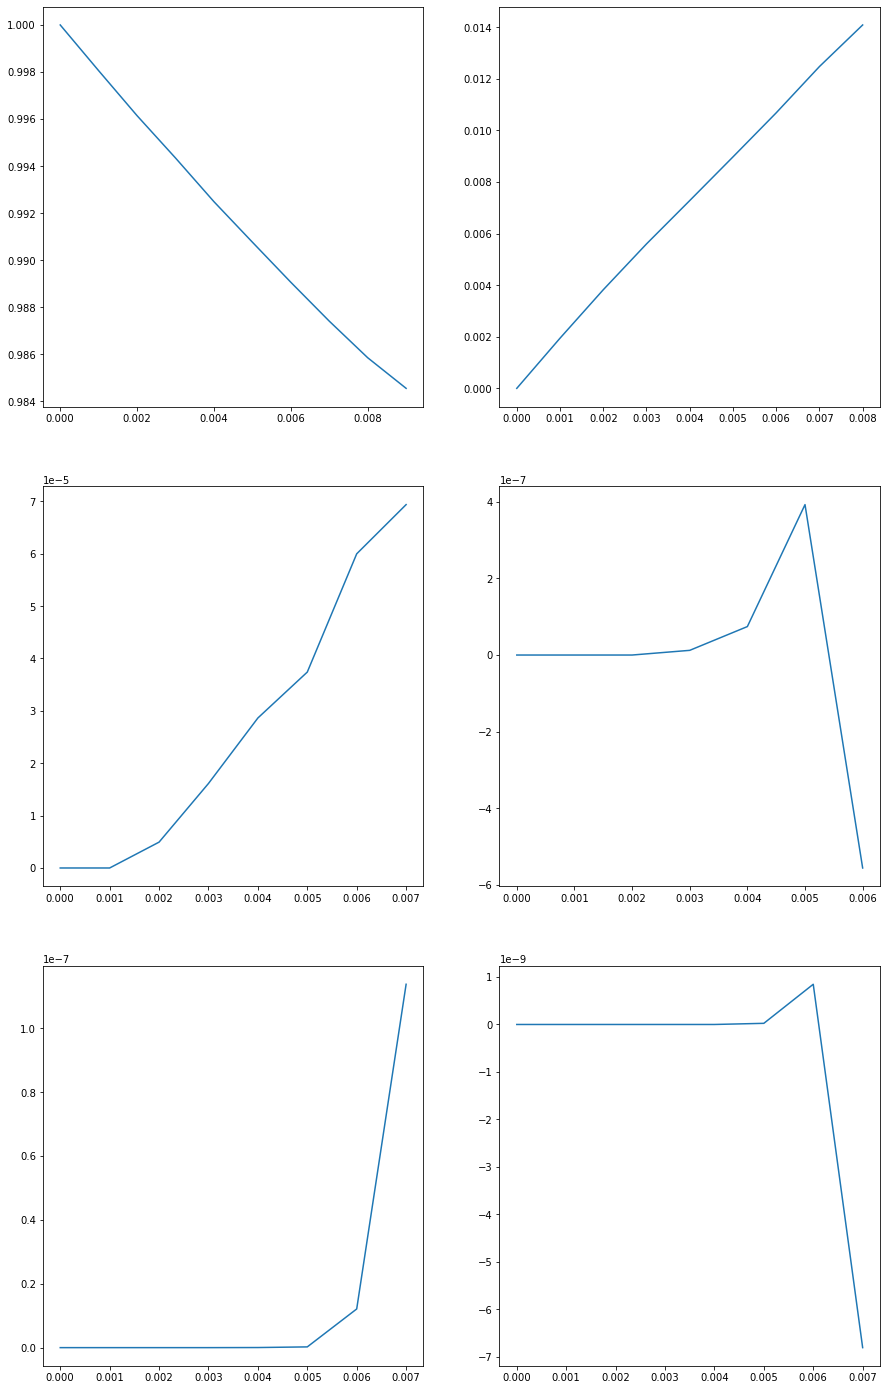

In [122]:
# Plot  
fig, ax = plt.subplots(3, 2, figsize = (15, 25))
for a, i in zip(ax.flatten(), range(len(sde_results))):
    a.plot(trange, sde_results[i])